In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2


In [2]:
import json
import numpy as np
from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pickle
import re
from collections import defaultdict
from features import merge_entries
from utills import chunker
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from fit_pan_topc_model import preprocess_for_topics, noop
import tikzplotlib
import gzip
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib notebook

In [3]:
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
# PREPROCESSED_DATA_PATH = '../temp_data/reddit/preprocessed/'
# COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'
# TEMP_DATA_PATH = '../temp_data/reddit/topic_similarity/'
# FIGURES_PATH = '../figures/'

MODEL_PATH = '../temp_data/pan/model.p'
DATA_DIR = '../data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
DATA_PATH = DATA_DIR + 'pan20-authorship-verification-training-large.jsonl'
PREPROCESSED_DATA_PATH = '../temp_data/pan/'
TEMP_DATA_PATH = '../temp_data/pan/topic_similarity/'
FIGURES_PATH = '../figures/'

Load Topic Model
===

In [5]:
# Fit the model using fit_reddit_topic_models.py
with open(TEMP_DATA_PATH + 'pan_topic_model_chunked.p', 'rb') as f:
    (nmf, transformer) = pickle.load(f)

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
display_topics(nmf, transformer.get_feature_names(), 20)

Topic 0:
make sure wasn making happy sense more try better keep work doesn able things wouldn trying enough idea bit least
Topic 1:
my myself mine god pov hear heart our put dear walk bag mind turn oh parents holmes fault pull lady
Topic 2:
felt feel body feeling heart pain herself cold mind stomach chest warm warmth tears fear feelings being emotions heat breath
Topic 3:
said oh hey looking smiling okay walked went yelled ran well shouted ok walking thank gwen jamie pointing started yeah
Topic 4:
they themselves found weren parents everyone went ship friends arrived people family team heard find talked came others agreed safe
Topic 5:
* ^ jenny lizzie matt bang squall lin end f evil flashback ] ethan cough ya christian [ fic %
Topic 6:
is does isn looks knows makes feels seems takes doesn wants reason thinks believe comes true means gets place dead
Topic 7:
we our find guys found ourselves everyone nodded team plan ship agreed friends suggested well start idea continue meet haven
Topi

In [8]:
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']

Compute Similarities
===

In [9]:
nmf.verbose = 0
chunk_sz = 2

In [ ]:

similarities = []
labels = []

with open(PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl', 'r') as f:
    for line in tqdm(f, total=81963):
        if np.random.rand() > 0.1:
            continue
        d = json.loads(line)
        

        prepped = [preprocess_for_topics(merge_entries(c)) for c in chunker(d['pair'][0], chunk_sz)]
        d1 = [c for c in prepped if len(c) > 0]

        prepped = [preprocess_for_topics(merge_entries(c)) for c in chunker(d['pair'][1], chunk_sz)]
        d2 = [c for c in prepped if len(c) > 0]
        
        x1 = normalize(nmf.transform(transformer.transform(d1))).mean(axis=0)
        x2 = normalize(nmf.transform(transformer.transform(d2))).mean(axis=0)
        similarities.append(1 - cosine(x1, x2))
        labels.append(ground_truth[d['id']])


In [ ]:
similarities = np.array(similarities)
labels = np.array(labels)

Topic Similarity Distributions
====

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(
        x=similarities[labels==True],
        name='Same Author'
    ))
fig.add_trace(go.Histogram(
        x=similarities[labels==False],
        name='Diff Author'
    ))


fig.show()

In [ ]:
fig, ax = plt.subplots()

ax.hist(similarities[labels==True], bins=60, alpha=0.5, density=True)
ax.hist(similarities[labels==False], bins=60, alpha=0.5, density=True)

ax.set_xlabel('Topic Similarity')

ax.legend(labels=['Same Author','Diff Author'], loc='best')
plt.tight_layout()

plt.show()

Analyse Misclassifications
===

In [10]:
with open(MODEL_PATH, 'rb') as f:
    (clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc) = pickle.load(f)

In [11]:

similarities = []
labels = []
probs = []
with open(PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl', 'r') as f:
    for line in tqdm(f, total=81963):
#         if np.random.rand() > 0.1:
#             continue
        d = json.loads(line)
        

        prepped = [preprocess_for_topics(merge_entries(c)) for c in chunker(d['pair'][0], chunk_sz)]
        d1 = [c for c in prepped if len(c) > 0]

        prepped = [preprocess_for_topics(merge_entries(c)) for c in chunker(d['pair'][1], chunk_sz)]
        d2 = [c for c in prepped if len(c) > 0]
        
        x1 = normalize(nmf.transform(transformer.transform(d1))).mean(axis=0)
        x2 = normalize(nmf.transform(transformer.transform(d2))).mean(axis=0)
        similarities.append(1 - cosine(x1, x2))
        labels.append(ground_truth[d['id']])
        
        x1 = scaler_nc.transform(transformer_nc.transform([merge_entries(d['pair'][0])]).todense())
        x2 = scaler_nc.transform(transformer_nc.transform([merge_entries(d['pair'][1])]).todense())
        p = clf_nc.predict_proba(secondary_scaler_nc.transform(np.abs(x1-x2)))[0, 1]
        probs.append(p)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning:

invalid value encountered in double_scalars



In [12]:
similarities = np.array(similarities)
labels = np.array(labels)
probs = np.array(probs)

In [13]:
with open(TEMP_DATA_PATH + 'topic_similarity_results.p', 'wb') as f:
    pickle.dump((
        similarities,
        labels,
        probs
        ), f)

In [5]:
with open(TEMP_DATA_PATH + 'topic_similarity_results.p', 'rb') as f:
    (
        similarities,
        labels,
        probs
    ) = pickle.load(f)

In [6]:
TPs = np.logical_and(labels == True, probs >= 0.5)
FPs = np.logical_and(labels == False, probs >= 0.5)

TNs = np.logical_and(labels == False, probs < 0.5)
FNs = np.logical_and(labels == True, probs < 0.5)

In [15]:
fig = go.Figure()
fig.add_trace(go.Histogram(
        x=similarities[labels==False],
        name='Same Author, Diff topic',
        histnorm='probability'
    ))
fig.add_trace(go.Histogram(
        x=similarities[FPs],
        name='Same Author, Diff topic',
        histnorm='probability'
    ))
fig.show()

In [16]:
fig = go.Figure()
fig.add_trace(go.Histogram(
        x=similarities[labels==True],
        name='Same Author, Diff topic',
        histnorm='probability'
    ))
fig.add_trace(go.Histogram(
        x=similarities[FNs],
        name='Same Author, Diff topic',
        histnorm='probability'
    ))
fig.show()

In [18]:
def compute_cohensd(X1, X2):
    X1_mean = X1.mean(axis=0)
    X2_mean = X2.mean(axis=0)
    # pos_std = X[Y==1].std(axis=0)
    # neg_std = X[Y==0].std(axis=0)
    # cd1 = 2 * (pos_mean - neg_mean) / (pos_std + neg_std)
#     std = np.std(np.concatenate([X1, X2]))
    std = np.sqrt((np.std(X1) ** 2 + np.std(X2) ** 2) / 2)
    # cd2 = (pos_mean - neg_mean) / std
    # print(cd1, cd2)
    return (X1_mean - X2_mean)/std

In [10]:
compute_cohensd(similarities[labels==True], similarities[FNs])

0.2097595107532858

In [16]:
similarities[np.isnan(similarities)] = 0

In [19]:
compute_cohensd(similarities[labels==False], similarities[FPs])

-0.1507944469075343

In [57]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [49]:
TEXT_WIDTH = 7.0 
COL_WIDTH = (TEXT_WIDTH - 0.5)/2
HEIGHT = 3.0

style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=7

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  

<IPython.core.display.Javascript object>


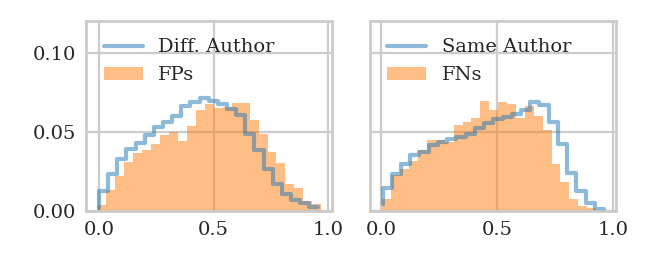

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(COL_WIDTH, 1.3), sharey=True)

nbins = 25
arr = similarities[labels==False]
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
ax[0].step(edges[:-1], results * binWidth, binWidth, alpha=0.5, color=colors[0])

arr = similarities[FPs]
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
ax[0].bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[1])

legend_elements = [Line2D([0], [0], color=colors[0], label='Diff. Author', alpha=0.5),
                   Patch(facecolor=colors[1], label='FPs',alpha=0.5)]
ax[0].legend(handles=legend_elements, loc='upper left')


# ax[1].hist(similarities[labels==True], ec='blue', histtype='step', fc='none', bins=nbins, alpha=0.5, density=True)
# ax[1].hist(similarities[FNs], bins=nbins, alpha=0.5, density=True)
# # ax[1].set_xlabel('Topic sim. among FNs w.r.t all same author pairs')
# ax[1].legend(labels=['Same Author','FNs'], loc='upper left')

arr = similarities[labels==True]
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
ax[1].step(edges[:-1], results * binWidth, binWidth, alpha=0.5, color=colors[0])

arr = similarities[FNs]
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
ax[1].bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[1])
legend_elements = [Line2D([0], [0], color=colors[0], label='Same Author', alpha=0.5),
                   Patch(facecolor=colors[1], label='FNs',alpha=0.5)]
ax[1].legend(handles=legend_elements, loc='upper left')



ax[0].set_ylim([0, .12])

plt.tight_layout()

plt.show()


plt.savefig(FIGURES_PATH + 'pan_topic_similarity_small_new.pdf')

In [55]:
p1, p2

([<matplotlib.lines.Line2D at 0x7fd0d15abbe0>,
 <BarContainer object of 25 artists>)

<IPython.core.display.Javascript object>


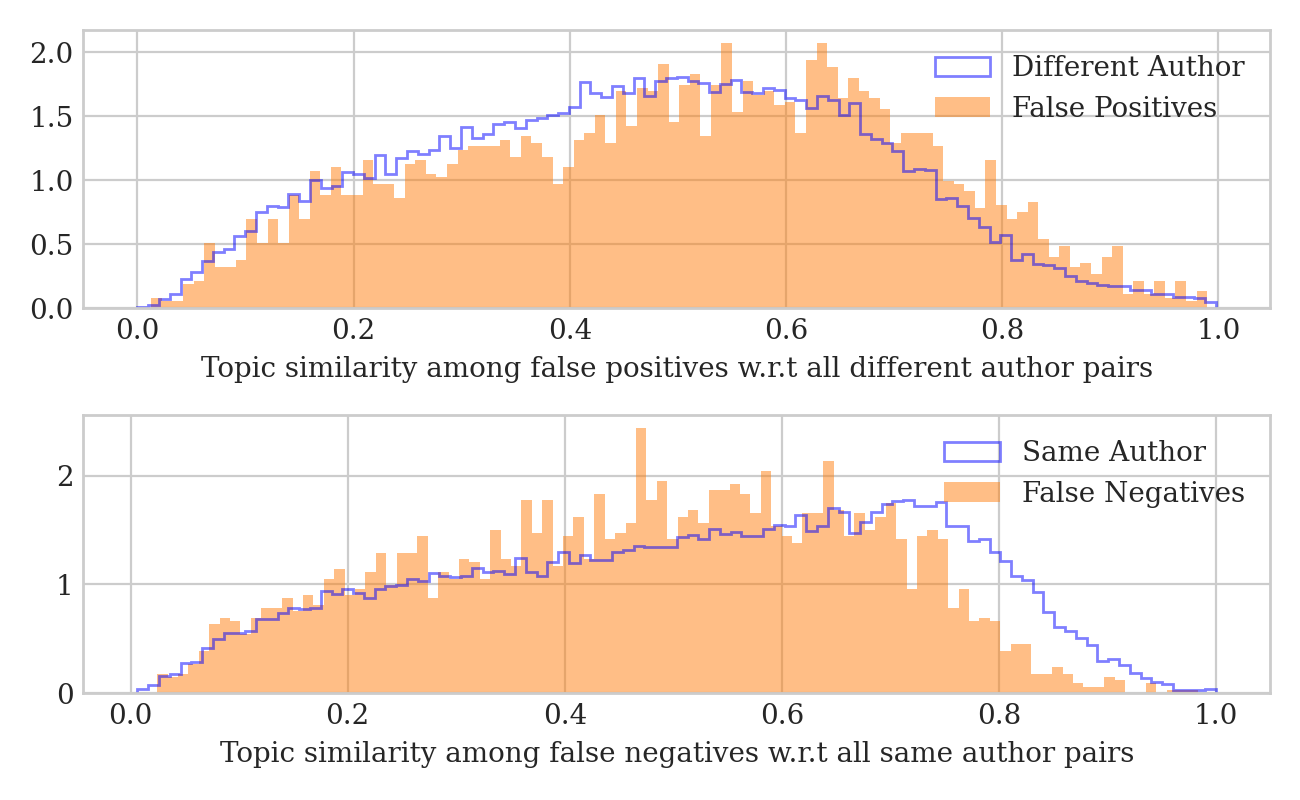

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(WIDTH, HEIGHT))


ax[0].hist(similarities[labels==False], ec='blue', histtype='step', fc='none', bins=100, alpha=0.5, density=True)
ax[0].hist(similarities[FPs], bins=100, alpha=0.5, density=True)
ax[0].set_xlabel('Topic similarity among false positives w.r.t all different author pairs')
ax[0].legend(labels=['Different Author','False Positives'], loc='upper right')


ax[1].hist(similarities[labels==True], ec='blue', histtype='step', fc='none', bins=100, alpha=0.5, density=True)
ax[1].hist(similarities[FNs], bins=100, alpha=0.5, density=True)
ax[1].set_xlabel('Topic similarity among false negatives w.r.t all same author pairs')
ax[1].legend(labels=['Same Author','False Negatives'], loc='upper right')


plt.tight_layout()

plt.show()


plt.savefig(FIGURES_PATH + 'pan_topic_similarity.pdf')

<IPython.core.display.Javascript object>


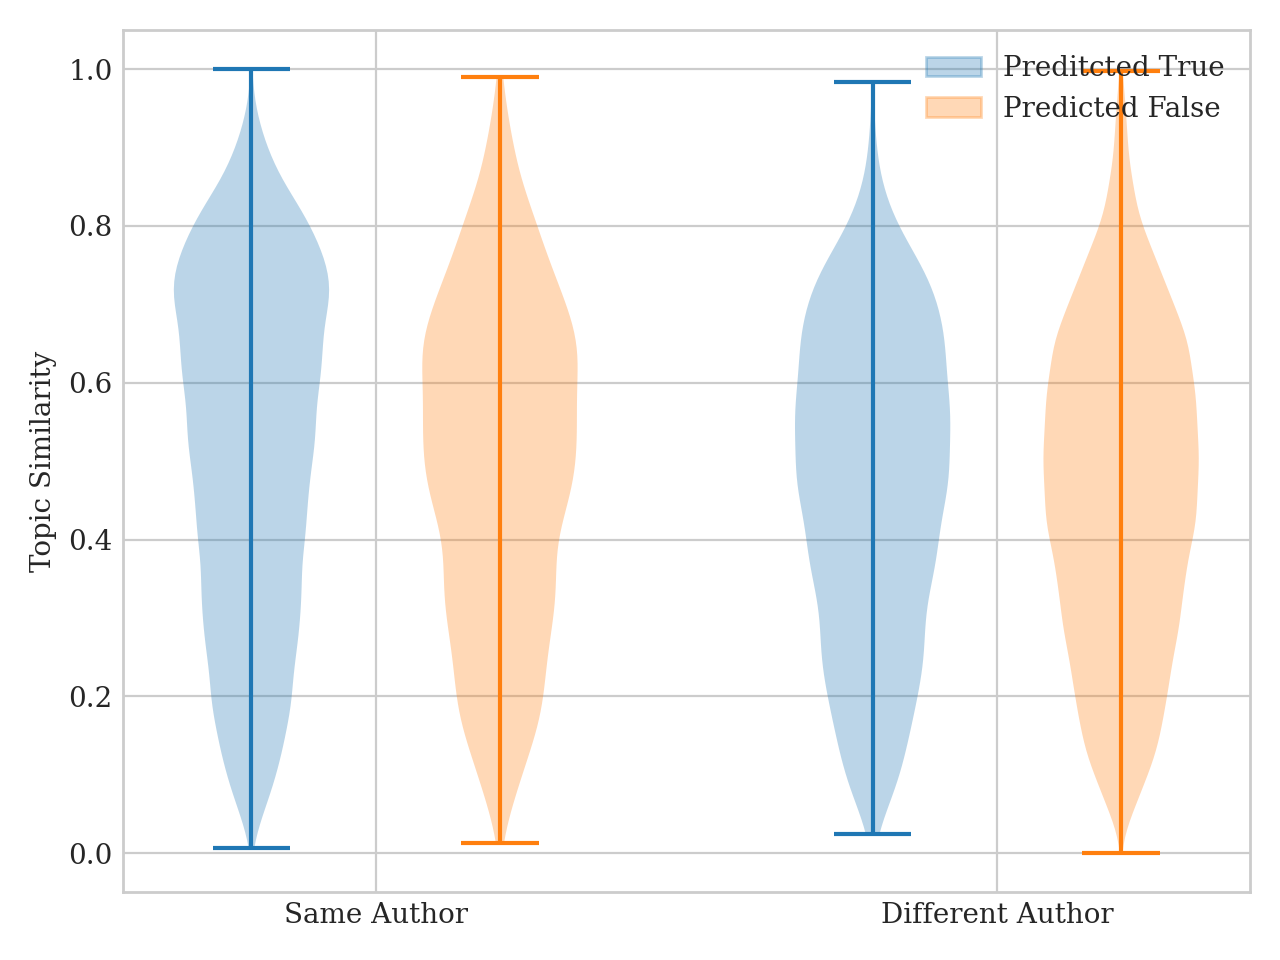

In [23]:
fig, ax = plt.subplots()

v1 = ax.violinplot([
    similarities[np.logical_and(probs > 0.5, labels==True)],
    similarities[np.logical_and(probs < 0.5, labels==True)],
], positions=[-0.4,  1.6 ])



v2 = ax.violinplot([
    similarities[np.logical_and(probs > 0.5, labels==False)],
    similarities[np.logical_and(probs < 0.5, labels==False)]
], positions=[0.4, 2.4])

colors = [mpatches.Patch(color=v1['bodies'][0].get_facecolor().flatten()), mpatches.Patch(color=v2['bodies'][0].get_facecolor().flatten())]
legend_names = ['Preditcted True', 'Predicted False']
plt.legend(colors, legend_names, loc='best')


plt.ylabel('Topic Similarity')
plt.xticks([0, 2], ['Same Author', 'Different Author'])
plt.tight_layout()
# tikzplotlib.save(FIGURES_PATH + 'violin_reddit_topic_similarity.pgf', axis_height='0.5\\textwidth')
# plt.savefig(FIGURES_PATH + 'violin_reddit_topic_similarity.png')

In [21]:
similarities[np.isnan(similarities)] = 0